In [1]:
import pandas as pd
import pickle
import random
from rdkit import Chem
import itertools
import torch
import numpy as np
from enhancement_utility import generate_smiles, smiles_to_fingerprint

seed = 12

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
df = pd.read_csv('borylation_cleaned.csv', index_col=False)
print(df.head())
pickle_path = 'borylation.pkl'

with open(pickle_path, 'rb') as f:
    model = pickle.load(f)

proxy_model = model.predict
THRESHOLD = 0.12

                         Electrophile  \
0  O=S(OC1=CC=C2C(C=CN2)=C1)(N(C)C)=O   
1  O=S(OC1=CC=C2C(C=CN2)=C1)(N(C)C)=O   
2  O=S(OC1=CC=C2C(C=CN2)=C1)(N(C)C)=O   
3  O=S(OC1=CC=C2C(C=CN2)=C1)(N(C)C)=O   
4  O=S(OC1=CC=C2C(C=CN2)=C1)(N(C)C)=O   

                                              ligand solvent   yield  
0        CN(C)C(C=C1)=CC=C1P(C2=CC=CC=C2)C3=CC=CC=C3      CO  0.8886  
1  CCCCC1(C(C=CC=C2)=C2C3=C1C=CC=C3)P(C4CCCCC4)C5...      CO  0.5407  
2          C1(P(C2=CC=CN2C3=CC=CC=C3)C4CCCCC4)CCCCC1      CO  0.7499  
3  C1(P(C2=CC=NN2C3=C(C4=CC=CC=C4)N(C5=CC=CC=C5)N...      CO  0.8292  
4        C1(P(C2=CC=CC=C2C3=CC=CC=C3)C4CCCCC4)CCCCC1      CO  0.8025  


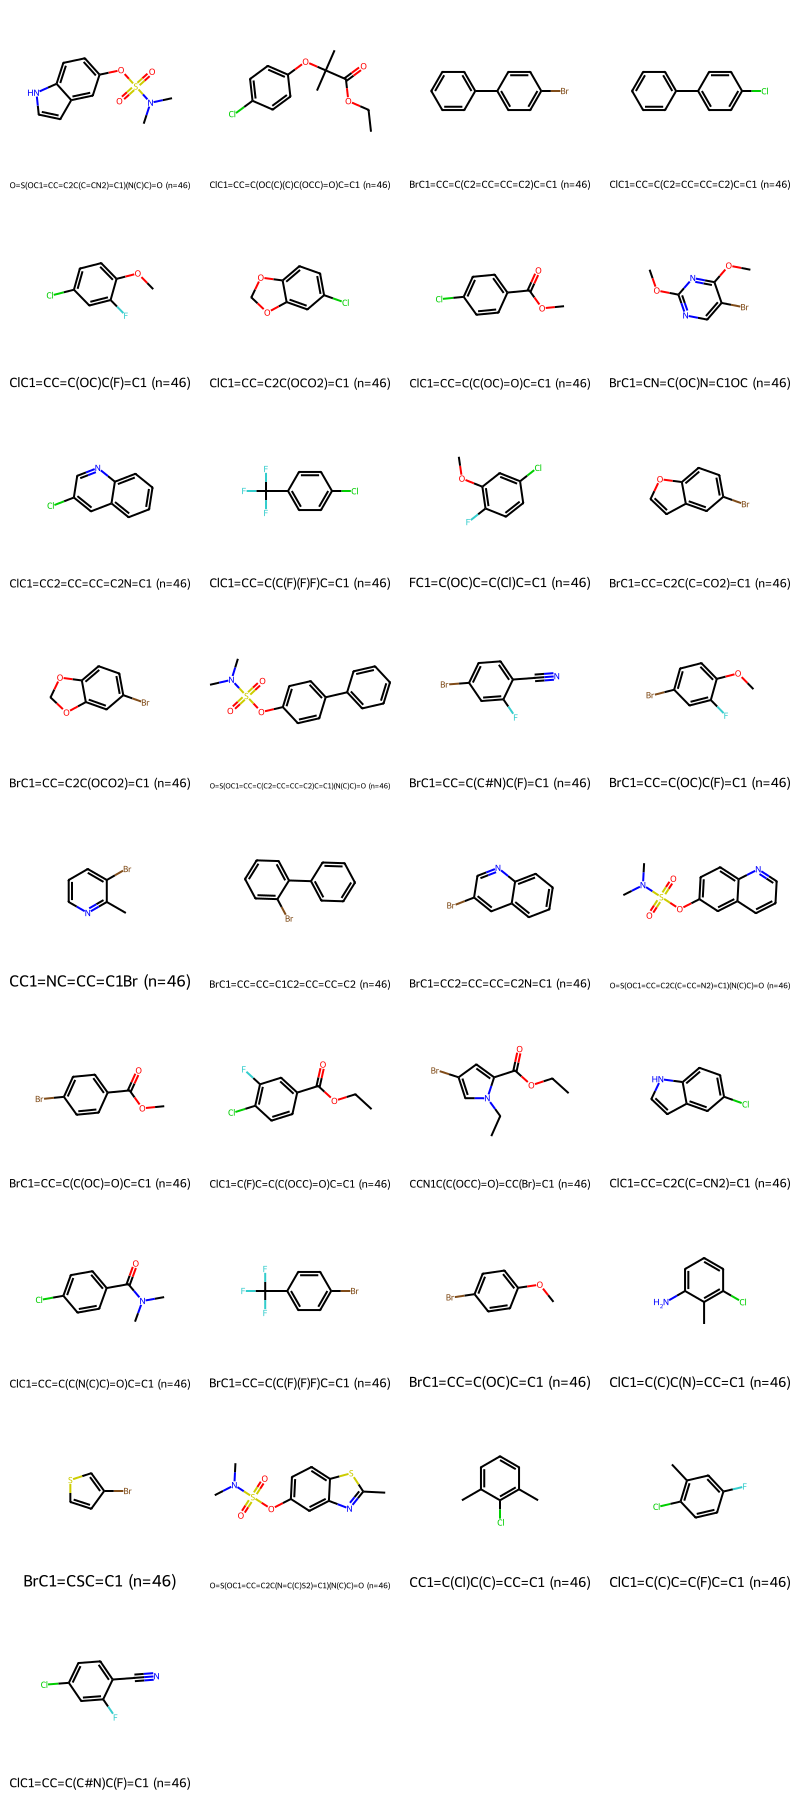

In [3]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Assuming df is your DataFrame and the column containing SMILES is called 'Nucleophile'

# Calculate the frequency of each unique SMILES
frequency = df['Electrophile'].value_counts()

# Create a DataFrame with unique nucleophiles and their counts
unique_nucleophiles = pd.DataFrame({
    'Electrophile': frequency.index,
    'Count': frequency.values
})

# Convert each unique SMILES to an RDKit Molecule object
unique_nucleophiles['Molecule'] = unique_nucleophiles['Electrophile'].apply(Chem.MolFromSmiles)

# Prepare the list of molecules and the legends (SMILES + count)
mols = unique_nucleophiles['Molecule'].tolist()
legends = [f"{smi} (n={count})" for smi, count in zip(unique_nucleophiles['Electrophile'], unique_nucleophiles['Count'])]

# Draw the molecules in a grid with the frequency in the legend
img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200), legends=legends)

# Display the image within the Jupyter notebook
display(img)

In [4]:
electrophiles = df['Electrophile'].tolist()
random.shuffle(electrophiles)
ligands = list(set(df['ligand'].tolist()))
solvents = list(set(df['solvent'].tolist()))

electrophiles_enhanced = []

In [5]:
for electrophile in electrophiles:
    electrophiles_enhanced.extend(generate_smiles(electrophile))

In [6]:
electrophile_pattern_Cl = Chem.MolFromSmarts('[c]Cl')
electrophile_pattern_Br = Chem.MolFromSmarts('[c]Br')
electrophile_pattern_S = Chem.MolFromSmarts('[c][O][S](=O)(=O)[N](C)[C]')
electrophiles_filtered = []

for smi in electrophiles_enhanced:
    mol = Chem.MolFromSmiles(smi)
    if mol.HasSubstructMatch(electrophile_pattern_Cl) or mol.HasSubstructMatch(electrophile_pattern_Br) or mol.HasSubstructMatch(electrophile_pattern_S):
        electrophiles_filtered.append(smi)

electrophiles_filtered = list(set(electrophiles_filtered))
print(len(electrophiles_filtered))

3418


In [7]:
combinations = list(itertools.product(ligands, solvents, electrophiles_filtered))
print(len(combinations), len(electrophiles_filtered))
df_enhanced = pd.DataFrame(combinations, columns=['ligand', 'solvent', 'Electrophile'])
print(df_enhanced.head(), len(df_enhanced))

157228 3418
                                              ligand solvent  \
0  COC1=CC=CC=C1C2=C(P(C3CCCCC3)C4CCCCC4)C5=C6C=C...      CO   
1  COC1=CC=CC=C1C2=C(P(C3CCCCC3)C4CCCCC4)C5=C6C=C...      CO   
2  COC1=CC=CC=C1C2=C(P(C3CCCCC3)C4CCCCC4)C5=C6C=C...      CO   
3  COC1=CC=CC=C1C2=C(P(C3CCCCC3)C4CCCCC4)C5=C6C=C...      CO   
4  COC1=CC=CC=C1C2=C(P(C3CCCCC3)C4CCCCC4)C5=C6C=C...      CO   

                       Electrophile  
0  CCc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1  
1             CCn1cc(Br)cc1C(=O)OCP  
2             CCn1cc(Br)cc1C(=O)OBr  
3             CN(C)[C-]c1ccc(Cl)cc1  
4       Cc1[c-]ccc(-c2ccc(Br)cc2)c1   157228


In [8]:
fingerprints = []
for index, row in df_enhanced.iterrows():
    ligand_fp = smiles_to_fingerprint(row['ligand'])
    solvent_fp = smiles_to_fingerprint(row['solvent'])
    electrophile_fp = smiles_to_fingerprint(row['Electrophile'])

    concatenated_fp = torch.cat((ligand_fp, solvent_fp, electrophile_fp))
    fingerprints.append(concatenated_fp)
    
X = torch.stack(fingerprints)
print(X.shape)

y = proxy_model(X)
print(y.shape)

df_enhanced['yield'] = y

print(df_enhanced.head(), len(df_enhanced))
print(len(df_enhanced['Electrophile'].unique()), len(df_enhanced['ligand'].unique()), len(df_enhanced['solvent'].unique()))

torch.Size([157228, 3072])
(157228,)
                                              ligand solvent  \
0  COC1=CC=CC=C1C2=C(P(C3CCCCC3)C4CCCCC4)C5=C6C=C...      CO   
1  COC1=CC=CC=C1C2=C(P(C3CCCCC3)C4CCCCC4)C5=C6C=C...      CO   
2  COC1=CC=CC=C1C2=C(P(C3CCCCC3)C4CCCCC4)C5=C6C=C...      CO   
3  COC1=CC=CC=C1C2=C(P(C3CCCCC3)C4CCCCC4)C5=C6C=C...      CO   
4  COC1=CC=CC=C1C2=C(P(C3CCCCC3)C4CCCCC4)C5=C6C=C...      CO   

                       Electrophile     yield  
0  CCc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1  0.267276  
1             CCn1cc(Br)cc1C(=O)OCP  0.427298  
2             CCn1cc(Br)cc1C(=O)OBr  0.435032  
3             CN(C)[C-]c1ccc(Cl)cc1  0.675900  
4       Cc1[c-]ccc(-c2ccc(Br)cc2)c1  0.747193   157228
3418 23 2


In [9]:
print(df_enhanced['yield'].mean())

0.42472338106472


In [10]:
mean_yield = df_enhanced.groupby('Electrophile')['yield'].mean()

substrates_below_threshold = mean_yield[mean_yield < THRESHOLD].index

print(substrates_below_threshold)

df_enhanced = df_enhanced[df_enhanced['Electrophile'].isin(substrates_below_threshold)]

print(df_enhanced.head(), len(df_enhanced))
print(len(df_enhanced['Electrophile'].unique()), len(df_enhanced['ligand'].unique()), len(df_enhanced['solvent'].unique()))

Index(['BCc1cccc(C)c1Cl', 'C=Cc1cccc(C)c1Cl', 'C=[S+]COc1ncc(Br)c(OC)n1',
       'CBOc1ncc(Br)c(OC)n1', 'CCOc1ncc(Br)c(OC)n1', 'CCc1cccc(C)c1Cl',
       'COc1nc(OCF)ncc1Br', 'COc1nc(OCS)ncc1Br', 'COc1nc(OC[B-]=S)ncc1Br',
       'COc1nc(OC[O+])ncc1Br', 'COc1nc(OC[P+])ncc1Br', 'COc1nc(OC[S-])ncc1Br',
       'COc1nc(OS)ncc1Br', 'COc1ncc(Br)c(OC)n1', 'C[C+]c1cccc(C)c1Cl',
       'C[N+]COc1ncc(Br)c(OC)n1', 'Cc1ccc(C)c(Cl)c1C', 'Cc1cccc(C)c1Cl',
       'Cc1cccc(C=[N-])c1Cl', 'Cc1cccc(C=[P-])c1Cl', 'Cc1cccc(C=[S+])c1Cl',
       'Cc1cccc(CBr)c1Cl', 'Cc1cccc(CF)c1Cl', 'Cc1cccc(CI)c1Cl',
       'Cc1cccc(CO)c1Cl', 'Cc1cccc(CP)c1Cl', 'Cc1cccc(CS)c1Cl',
       'Cc1cccc(C[N+])c1Cl', 'Cc1cccc(C[N-])c1Cl', 'Cc1cccc(C[O-])c1Cl',
       'Cc1cccc(C[P-])c1Cl', 'Cc1cccc(C[S-])c1Cl', 'Cc1cccc([C+]#P)c1Cl',
       '[B+]=COc1nc(OC)ncc1Br', '[B-]Cc1cccc(C)c1Cl', '[C+]=[C+]c1cccc(C)c1Cl',
       '[C+]CCOc1ncc(Br)c(OC)n1', '[C+]Cc1cccc(C)c1Cl', '[C+]c1cccc(C)c1Cl',
       '[C-]COc1ncc(Br)c(OC)n1', '[C-]Cc1cccc(C

In [11]:
final_df = pd.concat([df, df_enhanced], ignore_index=True)

print(len(final_df), len(final_df['Electrophile'].unique()), len(final_df['ligand'].unique()), len(final_df['solvent'].unique()))
final_df.to_csv('borylation_enhanced.csv', index=False)

3450 75 23 2
